In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.spatial.distance import cdist

from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


Load data

In [2]:
image_normal_dataset = tf.data.Dataset.load("/content/drive/MyDrive/Dane/IDA/image_normal_train")
image_patology_dataset = tf.data.Dataset.load("/content/drive/MyDrive/Dane/IDA/image_patology_train")

image_normal=[]
for img in image_normal_dataset:
  image_normal.append(img.numpy())

image_patology=[]
for img in image_patology_dataset:
  image_patology.append(img.numpy())

# Augmentation with GAN

### Functions

In [3]:
# Otsu image binarization and segmentation of head areas
def mask(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = np.uint8(gray*255) 
  kernel = np.ones((3,3), np.uint8)
  img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) 
  ret3,th3 = cv2.threshold(img,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th3)

  # Create a new mask image where each object has a unique value
  mask = np.zeros(th3.shape, dtype=np.uint8)
  for i in range(1, num_labels):
      mask[labels == i] = i
  return mask

# Finding an extreme object (head skull)
def outer(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, 
                                           cv2.CHAIN_APPROX_SIMPLE)
    outer_contours=[]
    for i in range(len(hierarchy[0])):
        if hierarchy[0][i][3] == -1 and len(outer_contours)==0:
            outer_contours.append(i)
        if hierarchy[0][i][3] == 0:
            outer_contours.append(i)
    return outer_contours,contours

# Adding a mask without a skull to a mask with a skull 
# so that the intercranial space is also treated as an object
def color_mask(sample):
    m = mask(sample)
    outer_contours, contours = outer(m)
    img = np.zeros_like(m)
    for i,contour in enumerate(contours):
        if i in outer_contours:
            cv2.drawContours(img, [contour], 0, 1, -1)
    return img+m

# Creating a mask containing only pathologies
def mask_without_border(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist((img*255).astype(np.uint8))
  kernel = np.ones((3,3), np.uint8)
  ret3,img = cv2.threshold(img,180,255,cv2.THRESH_BINARY) 
  img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) 

  outer_contours, contours = outer(img)
  if len(outer_contours)==1:
      img = cv2.dilate(img,kernel,iterations = 1)
      outer_contours, contours = outer(img)
  img = np.zeros_like(img)
  for i,contour in enumerate(contours):
      if i not in outer_contours:
          cv2.drawContours(img, [contour], 0, 1, -1)
  return img

# Create pairs
def match_images(images1, images2):
    images1 = np.array(images1)
    images2 = np.array(images2)

    distances = cdist(images1.reshape(len(images1), -1), images2.reshape(len(images2), -1))
    matched_indices = np.argmin(distances, axis=1)
    
    first = []
    second = []

    for i, j in enumerate(matched_indices):
      first.append(images1[i])
      second.append(images2[j])
  
    dataset = tf.data.Dataset.from_tensor_slices((first,second))
    return dataset


## Segmentation

Masks of pathologies used for augmentation

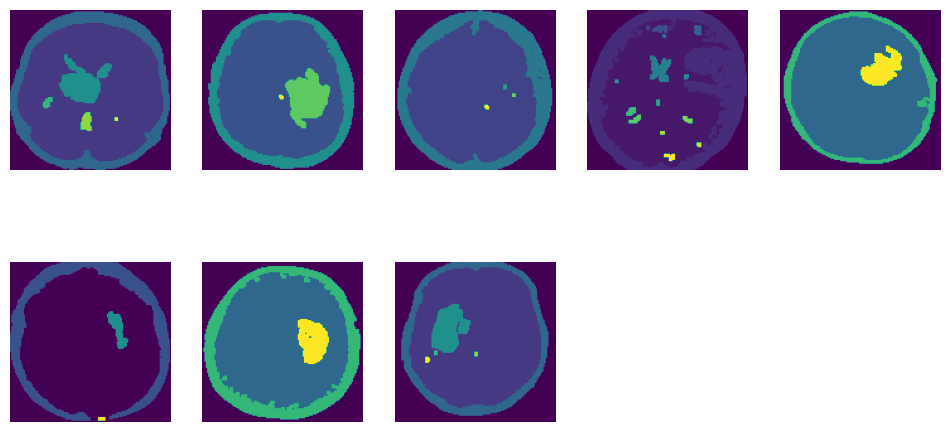

In [4]:
i=1
color_masks = []
plt.figure(figsize=[12,6])
for img in image_patology[2:]:
  plt.subplot(2,5,i)
  maska = color_mask(img)
  plt.imshow(maska)
  plt.axis("off")
  i+=1
  color_masks.append(np.repeat(maska[:, :,tf.newaxis].astype('float32'), 3, axis=2))

Create masks of normal images

In [5]:
color_masks_normal = []
for img in image_normal:
  maska = color_mask(img)
  color_masks_normal.append(np.repeat(maska[:, :,tf.newaxis].astype('float32'), 3, axis=2))

Creation of learning data for Pix2pix generative network

Learning data are created from both normal and pathology images,  
consist of pairs (mask, orginal image).

In [7]:
color_masks = tf.data.Dataset.from_tensor_slices((color_masks, image_patology[2:]))
color_masks_normal = tf.data.Dataset.from_tensor_slices((color_masks_normal, image_normal))

all_color_masks = color_masks.concatenate(color_masks_normal).shuffle(110)
# all_color_masks.save("/content/drive/MyDrive/Dane/IDA/all_image_segmented_for_generator_train")

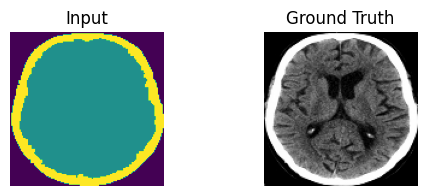

In [8]:
plt.figure(figsize=[6,2])
for normal, patology in color_masks_normal.take(1):
  plt.subplot(1,2,1)
  plt.imshow(normal.numpy()[:,:,1])
  plt.title("Input")
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(patology.numpy())
  plt.title("Ground Truth")
  plt.axis("off")

Create pairs by selecting for each image from the first list the most similar one from the second list.  

Similarity criterion: Smallest value of Euclidean distance.

In [9]:
pairs = match_images(image_normal, image_patology)

An example of a matched pair

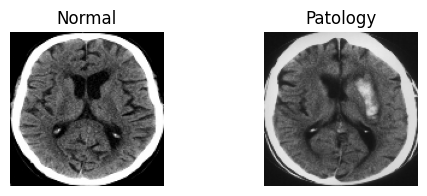

In [10]:
plt.figure(figsize=[6,2])
for normal, patology in pairs.take(1):
  plt.subplot(1,2,1)
  plt.imshow((normal.numpy()))
  plt.title("Normal")
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(patology.numpy())
  plt.title("Patology")
  plt.axis("off")

Create data for Pix2pix prediction (generation of new images).  
The data are pairs of images: the sum of the normal image mask and the pathology fragment mask, and the normal image as a reference.

In [11]:
pairs = tf.data.Dataset.load("/content/drive/MyDrive/Dane/IDA/pairs")
combined = []
nor=[]
for normal,patology in pairs:
  normal = normal.numpy()
  patology = patology.numpy()
  nor.append(normal)
  normal_mask = color_mask(normal)
  x = mask_without_border(patology)
  combined_mask = normal_mask + x*(normal_mask.max())
  combined.append(np.repeat(combined_mask[:, :,tf.newaxis].astype('float32'), 3, axis=2))

all_color_masks_combined = tf.data.Dataset.from_tensor_slices((combined, nor))
# all_color_masks_combined.save("/content/drive/MyDrive/Dane/IDA/all_color_masks_combined")

Example of input data for Pix2pix prediction

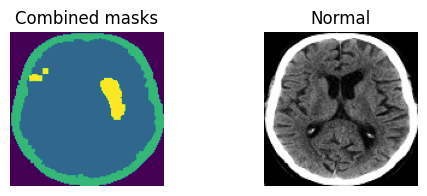

In [12]:
plt.figure(figsize=[6,2])
for mask, image in all_color_masks_combined.take(1):
  plt.subplot(1,2,1)
  plt.imshow(mask.numpy()[:,:,1])
  plt.title("Combined masks")
  plt.axis("off")
  plt.subplot(1,2,2)
  plt.imshow(image.numpy())
  plt.title("Normal")
  plt.axis("off")

## Pix2pix


### Functions

In [13]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0][:,:,1], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

def get_checkpoint_prefix():
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

  return checkpoint_prefix

### Training Pix2pix

Load data

In [14]:
# train_data = tf.data.Dataset.load("/content/drive/MyDrive/Dane/IDA/all_image_segmented_for_generator_train")
# test_data = tf.data.Dataset.load("/content/drive/MyDrive/Dane/IDA/all_color_masks_combined")
train_data = all_color_masks
test_data = all_color_masks_combined

Creation of the Pix2pix network

In [15]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      # downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(128, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(256, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(256, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(256, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(256, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(256, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(256, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(256, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(256, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(256, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(128, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(64, 4, norm_type),  # (bs, 64, 64, 256)
      # upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


def discriminator(norm_type='batchnorm', target=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

class Pix2pix(object):
  def __init__(self, epochs, enable_function):
    self.epochs = epochs
    self.enable_function = enable_function
    self.lambda_value = 100
    self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    self.generator = unet_generator(output_channels=3)
    self.discriminator = discriminator()
    self.checkpoint = tf.train.Checkpoint(
        generator_optimizer=self.generator_optimizer,
        discriminator_optimizer=self.discriminator_optimizer,
        generator=self.generator,
        discriminator=self.discriminator)

  def discriminator_loss(self, disc_real_output, disc_generated_output):
    real_loss = self.loss_object(
        tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = self.loss_object(tf.zeros_like(
        disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

  def generator_loss(self, disc_generated_output, gen_output, target):
    gan_loss = self.loss_object(tf.ones_like(
        disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (self.lambda_value * l1_loss)
    return total_gen_loss

  def train_step(self, input_image, target_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_output = self.generator(input_image, training=True)

      disc_real_output = self.discriminator(
          [input_image, target_image], training=True)
      disc_generated_output = self.discriminator(
          [input_image, gen_output], training=True)

      gen_loss = self.generator_loss(
          disc_generated_output, gen_output, target_image)
      disc_loss = self.discriminator_loss(
          disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_loss, self.generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(
        generator_gradients, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(
        discriminator_gradients, self.discriminator.trainable_variables))

    return gen_loss, disc_loss

  def train(self, data, checkpoint_pr):
    time_list = []
    if self.enable_function:
      self.train_step = tf.function(self.train_step)

    for epoch in range(self.epochs):
      for input_image, target_image in data:
        gen_loss, disc_loss = self.train_step(input_image, target_image)

      if (epoch + 1) % 20 == 0:
        self.checkpoint.save(file_prefix=checkpoint_pr)

      template = 'Epoch {}, Generator loss {}, Discriminator Loss {}'
      print (template.format(epoch, gen_loss, disc_loss))

    return time_list

In [16]:
pix = Pix2pix(300,True)

Training networks to map relationships between images and their segmented masks.

In [17]:
pix.train(train_data.shuffle(500).batch(1).prefetch(1), get_checkpoint_prefix())

Epoch 0, Generator loss 9.328550338745117, Discriminator Loss 1.3653888702392578
Epoch 1, Generator loss 9.1254243850708, Discriminator Loss 1.143070936203003
Epoch 2, Generator loss 6.189130783081055, Discriminator Loss 1.58817720413208
Epoch 3, Generator loss 11.009969711303711, Discriminator Loss 1.4757177829742432
Epoch 4, Generator loss 10.53913688659668, Discriminator Loss 1.3563134670257568
Epoch 5, Generator loss 9.233718872070312, Discriminator Loss 1.088417887687683
Epoch 6, Generator loss 10.561788558959961, Discriminator Loss 1.3282878398895264
Epoch 7, Generator loss 7.987774848937988, Discriminator Loss 0.9812431335449219
Epoch 8, Generator loss 8.479482650756836, Discriminator Loss 1.757145881652832
Epoch 9, Generator loss 9.04140853881836, Discriminator Loss 1.9002450704574585
Epoch 10, Generator loss 8.173027038574219, Discriminator Loss 1.0392059087753296
Epoch 11, Generator loss 5.572264194488525, Discriminator Loss 1.278245210647583
Epoch 12, Generator loss 8.499228

[]

Generator predicates for normal masks with added pathology fragment mask.

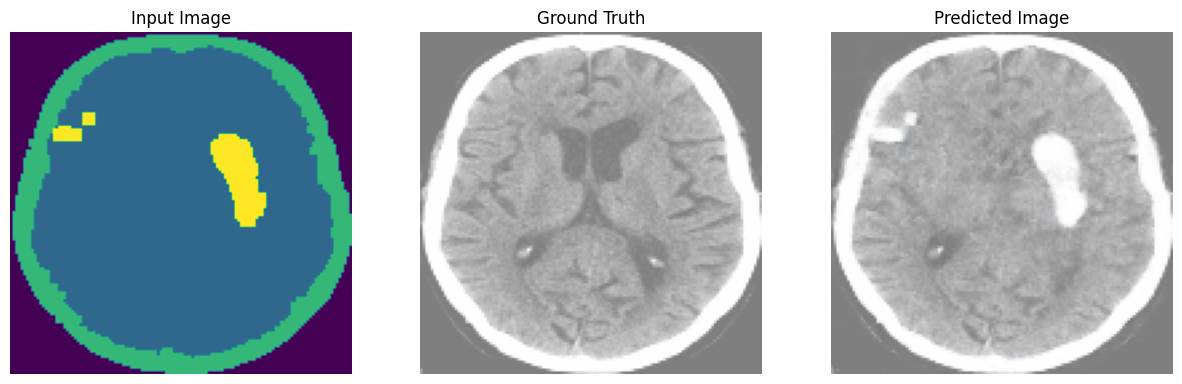

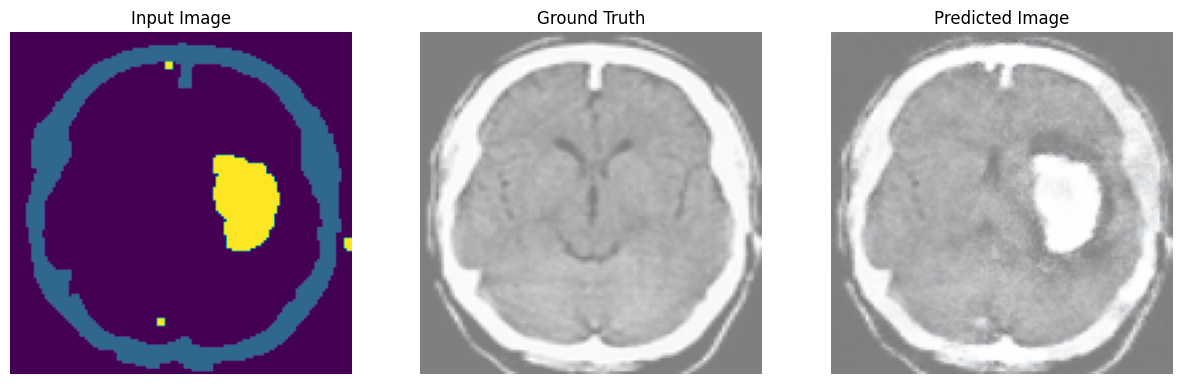

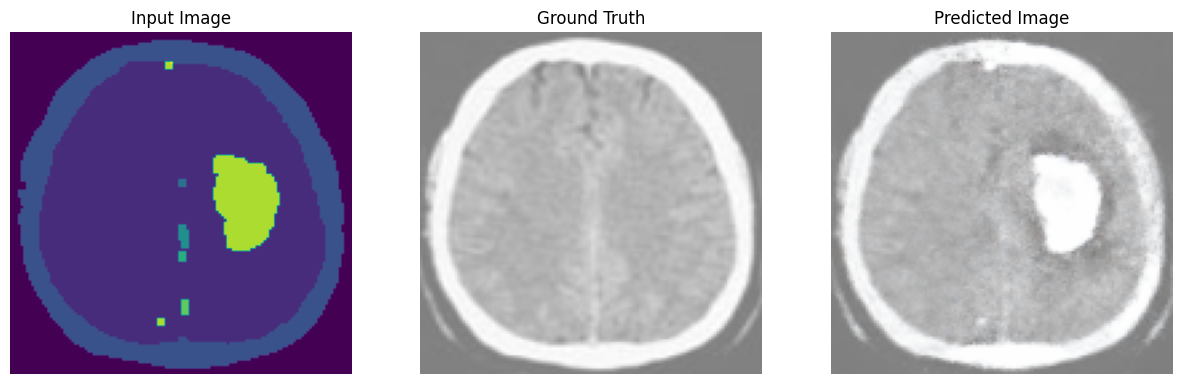

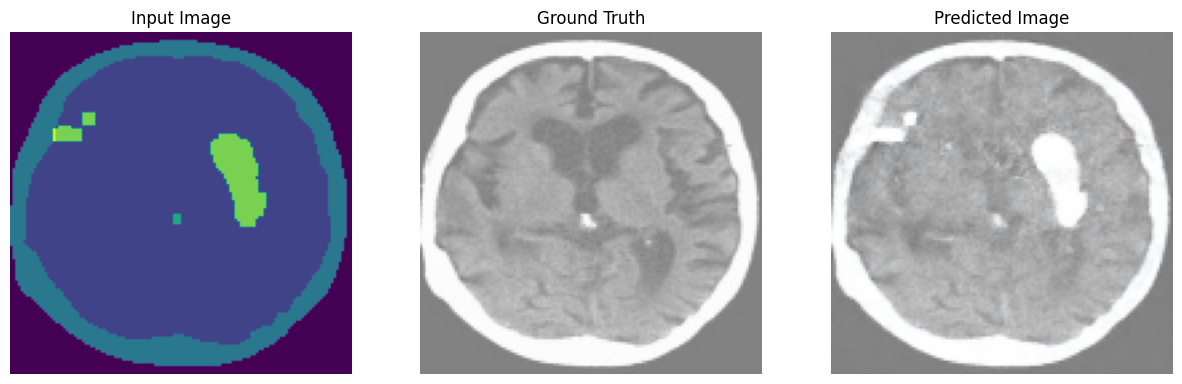

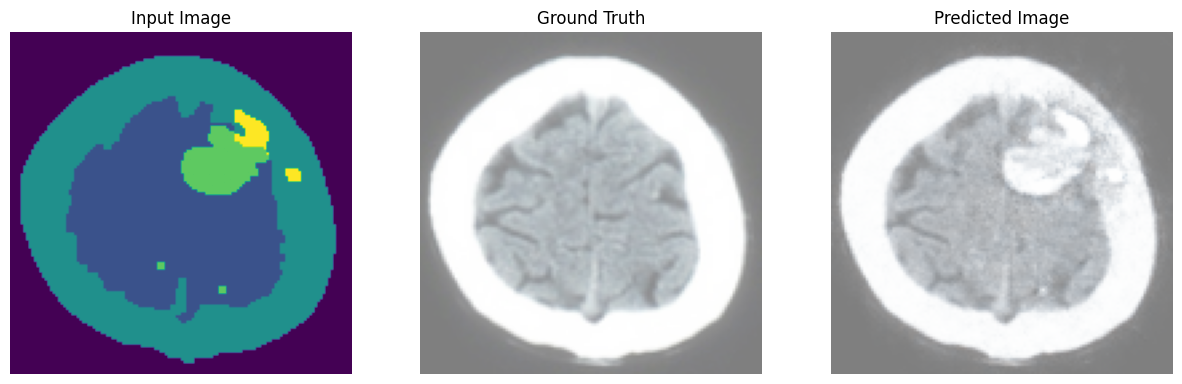

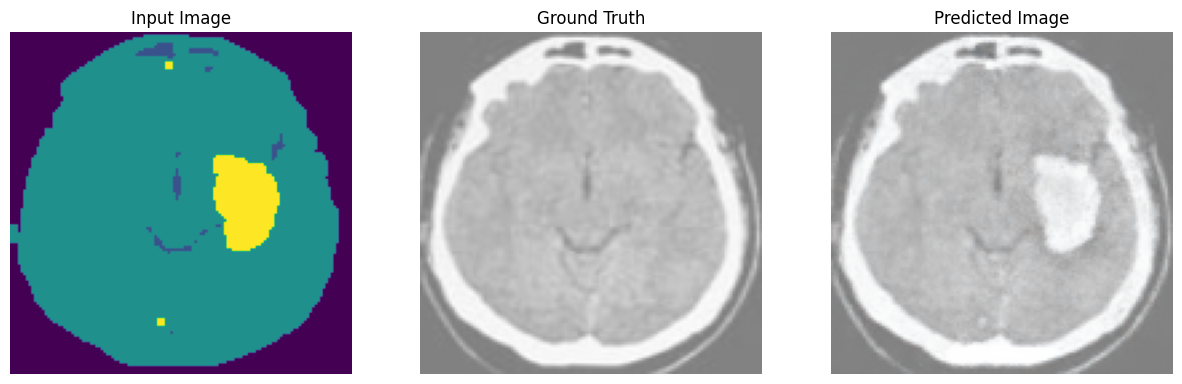

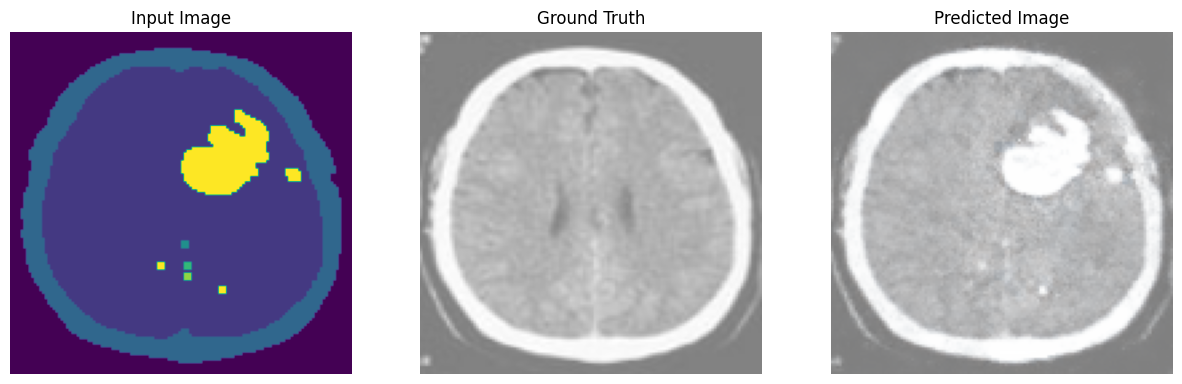

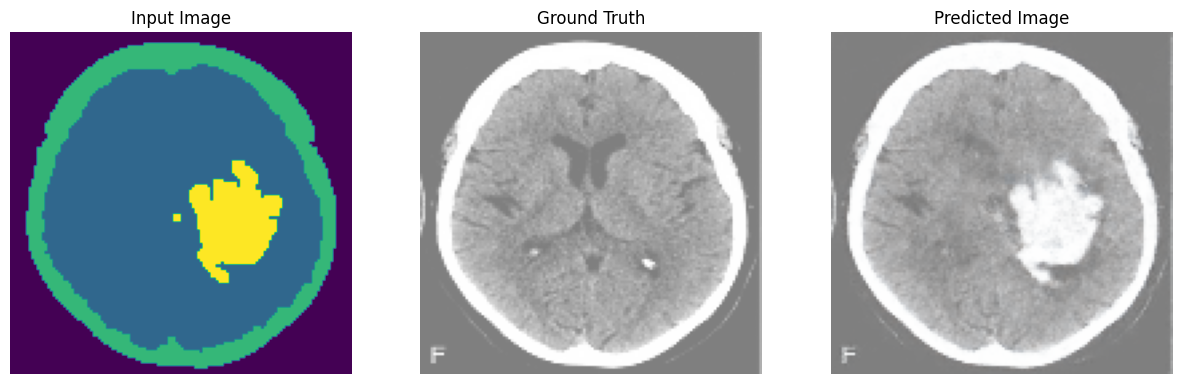

In [19]:
for example_input, example_target in test_data.take(8).batch(1):
  generate_images(pix.generator, example_input, example_target)
  generated_images = pix.generator(example_input, training=True)

Generate images with pathology for each normal image (90 samples)

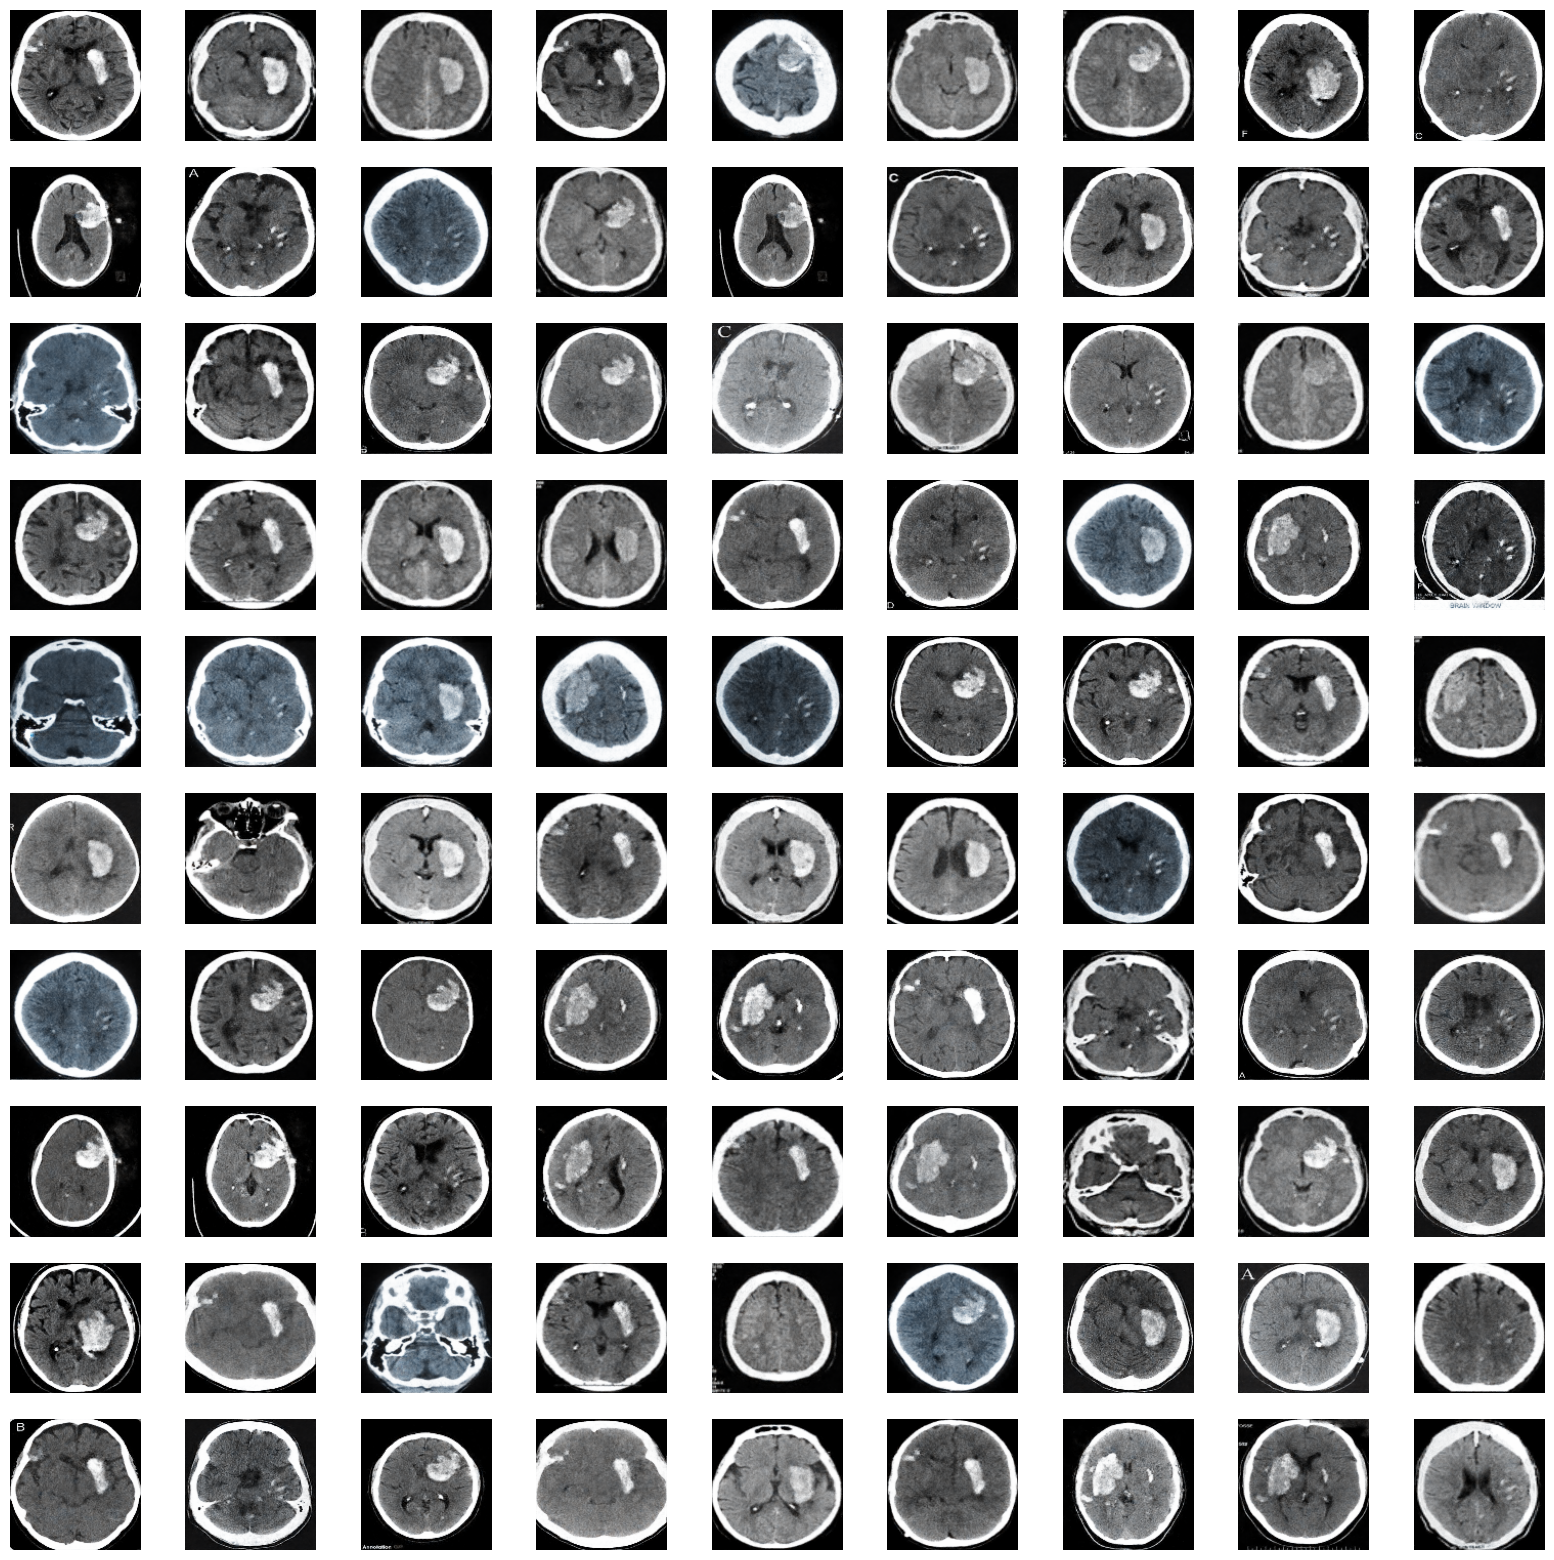

In [26]:
generated_images = []
plt.figure(figsize=[20,20])
for mask,image in test_data:
  new_image = pix.generator(mask[tf.newaxis,...], training=True)
  plt.subplot(10,9,len(generated_images)+1)
  plt.imshow(new_image[0])
  plt.axis('off') 
  generated_images.append(new_image[0])

Saving the generated images

In [21]:
generated = tf.data.Dataset.from_tensor_slices(generated_images)
# generated.save("/content/drive/MyDrive/Dane/IDA/generated_pix2pix")

# Augmentation Copy-Paste

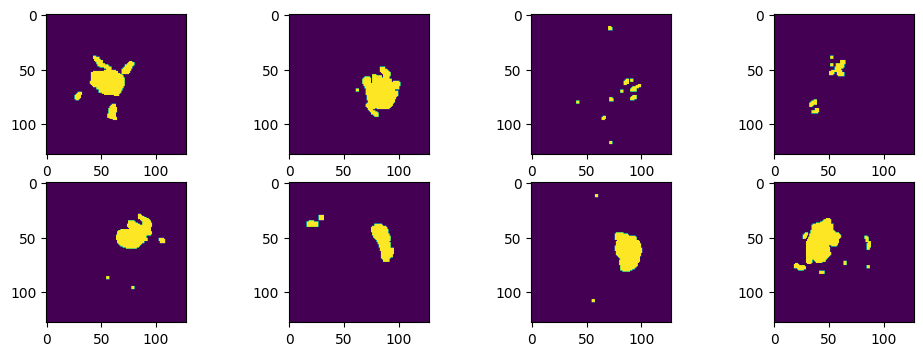

In [28]:
mask_patology = [mask_without_border(img) for img in image_patology[2:]]
i=1
plt.figure(figsize=[12,4])
for img in mask_patology:
  plt.subplot(2,4,i)
  plt.imshow(img)
  i+=1

### Copy-Paste

In [29]:
combined_images = []

for normal, patology in pairs:
    normal = normal.numpy()
    patology = patology.numpy()

    patology_mask = mask_without_border(patology)
    patology_mask = np.repeat(patology_mask[:, :,tf.newaxis].astype('float32'), 3, axis=2)

    normal_diff = normal-(patology_mask*normal)

    combined_image = normal_diff + (patology*patology_mask)
    combined_images.append(combined_image)

combined_images = tf.data.Dataset.from_tensor_slices(combined_images)
# combined_images.save("/content/drive/MyDrive/Dane/IDA/generated_paste")